In [1]:
# load libraries
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(arrow)))
suppressWarnings(suppressPackageStartupMessages(library(patchwork)))
suppressWarnings(suppressPackageStartupMessages(library(ggsignif)))
# import ggplot theme
source("../../utils/figure_themes.r")

In [2]:
# path to the anova data
anova_genotype_df_path <- file.path("..","..","data","6.analysis_results","anova_results_genotype.parquet")
anova_genotype_side_df_path <- file.path("..","..","data","6.analysis_results","anova_results_genotype_side.parquet")
anova_genotype_side_identity_df_path <- file.path("..","..","data","6.analysis_results","anova_results_genotype_side_identity.parquet")
data_path <- file.path("..","..","data","5.converted_data","normalized_feature_selected_output.parquet")

# read the data
data_df <- arrow::read_parquet(data_path)
head(data_df)

# read the anova data
anova_genotype_df <- arrow::read_parquet(anova_genotype_df_path)
anova_genotype_side_df <- arrow::read_parquet(anova_genotype_side_df_path)
anova_genotype_side_identity_df <- arrow::read_parquet(anova_genotype_side_identity_df_path)

Metadata_Image_FileName_OP,Metadata_ObjectNumber,Metadata_Object_ConvertImageToObjects_Number_Object_Number,Metadata_Object_ConvertImageToObjects_AreaShape_BoundingBoxArea,Metadata_Object_ConvertImageToObjects_AreaShape_BoundingBoxMaximum_X,Metadata_Object_ConvertImageToObjects_AreaShape_BoundingBoxMaximum_Y,Metadata_Object_ConvertImageToObjects_AreaShape_BoundingBoxMinimum_X,Metadata_Object_ConvertImageToObjects_AreaShape_BoundingBoxMinimum_Y,Metadata_Object_ConvertImageToObjects_Location_CenterMassIntensity_X_OP,Metadata_Object_ConvertImageToObjects_Location_CenterMassIntensity_Y_OP,⋯,Texture_SumEntropy_OP_3_02_256,Texture_SumEntropy_OP_3_03_256,Texture_SumVariance_OP_3_00_256,Texture_SumVariance_OP_3_01_256,Texture_SumVariance_OP_3_02_256,Texture_SumVariance_OP_3_03_256,Texture_Variance_OP_3_00_256,Texture_Variance_OP_3_01_256,Texture_Variance_OP_3_02_256,Texture_Variance_OP_3_03_256
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MAX_high_10_L.tiff,1,1,38250,269,182,44,12,131.5461,118.6411,⋯,0.8414748,0.8345736,1.14918564,1.1522001,1.07890507,1.14484796,1.04000878,1.02573996,1.04549223,1.02761705
MAX_high_10_R.tiff,1,1,34170,208,245,38,44,106.9621,162.3042,⋯,0.4524796,0.4361385,0.11217819,0.1319819,0.10860250,0.12569959,0.07571690,0.07120688,0.07647711,0.06792193
MAX_high_11_L.tiff,1,1,41736,250,267,62,45,131.3598,159.4445,⋯,0.4948130,0.4908441,-0.01613966,0.0010415,-0.02199706,-0.02099207,-0.03393425,-0.04263493,-0.03498345,-0.03876252
MAX_high_11_R.tiff,1,1,43616,212,272,24,40,101.0699,185.4864,⋯,0.8787288,0.8656168,1.12090459,1.1406044,1.07452904,1.11794134,1.03158516,1.01517198,1.03514983,1.01918842
MAX_high_12_L.tiff,2,2,25894,283,155,69,34,164.5791,105.2665,⋯,0.4767676,0.4826737,0.17788587,0.1479330,0.10331342,0.15645695,0.11176513,0.10784585,0.11761376,0.10885888
MAX_high_12_R.tiff,1,1,40920,229,265,43,45,119.3891,173.5103,⋯,0.1422418,0.1351928,-0.28744321,-0.2676854,-0.30011318,-0.29231741,-0.31932910,-0.32658057,-0.31978483,-0.32240245


In [3]:
# load levene data in 
levene_df_path <- file.path("..","..","data","6.analysis_results","levene_test_results.csv")
levene_df <- read.csv(levene_df_path)
# make a new column for ***
levene_df$significance <- ifelse(
    levene_df$levene_p_value < 0.001, "***", 
    ifelse(levene_df$levene_p_value < 0.01, "**", 
    ifelse(levene_df$levene_p_value < 0.05, "*", 
    "ns")
    )
)
head(levene_df)

,X,feature,levene_statistic,levene_p_value,group,significance
,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,429,RadialDistribution_ZernikePhase_OP_8_2,9.215577e-05,0.9923639,high_vs_wt,ns
2,441,Texture_AngularSecondMoment_OP_3_03_256,6.200963e-04,0.9801938,high_vs_wt,ns
3,149,RadialDistribution_ZernikeMagnitude_OP_6_4,6.497006e-04,0.9797298,high_vs_unsel,ns
4,143,RadialDistribution_ZernikeMagnitude_OP_4_4,7.542741e-04,0.9781598,high_vs_unsel,ns
5,560,AreaShape_Zernike_1_1,7.959461e-04,0.9775457,unsel_vs_wt,ns
6,275,AreaShape_InertiaTensor_0_0,8.132388e-04,0.9773188,high_vs_wt,ns


In [4]:
width <- 4
height <- 4
options(repr.plot.width = width, repr.plot.height = height)
# make a new column for the group1 and group2
anova_genotype_side_identity_df$comparison <- paste(anova_genotype_side_identity_df$group1, anova_genotype_side_identity_df$group2, sep = " - ")

# order the results by anova p-value
anova_genotype_side_identity_df <- anova_genotype_side_identity_df %>% arrange(anova_p_value)
features <- unique(anova_genotype_side_identity_df$feature)[1:10]
features
top_10_anova_genotype_side_identity_df <- anova_genotype_side_identity_df %>% filter(feature %in% features)
top_10_anova_genotype_side_identity_df$log10_tukey_p_value <- -log10(top_10_anova_genotype_side_identity_df$`p-adj`)
# make the genotype a factor
# replace the genotype values
data_df$Metadata_genotype <- gsub("wt", "Wild Type", data_df$Metadata_genotype)
data_df$Metadata_genotype <- gsub("unsel", "Mid-Severity", data_df$Metadata_genotype)
data_df$Metadata_genotype <- gsub("high", "High-Severity", data_df$Metadata_genotype)
data_df$Metadata_genotype <- factor(
    data_df$Metadata_genotype, 
    levels = c("Wild Type", "Mid-Severity", "High-Severity")
)
head(data_df)
# add features to the features list
features <- c(
    features,
    'AreaShape_HuMoment_0',
    'AreaShape_HuMoment_1',
    'AreaShape_HuMoment_2',
    'AreaShape_HuMoment_3',
    'AreaShape_HuMoment_4',
    'AreaShape_HuMoment_5',
    'AreaShape_HuMoment_6'
)

[1] "AreaShape_ConvexArea"           "AreaShape_MinFeretDiameter"    
 [3] "AreaShape_MinorAxisLength"      "AreaShape_Zernike_0_0"         
 [5] "AreaShape_Area"                 "AreaShape_CentralMoment_0_0"   
 [7] "AreaShape_SpatialMoment_0_0"    "AreaShape_EquivalentDiameter"  
 [9] "AreaShape_MedianRadius"         "Intensity_MeanIntensityEdge_OP"

Metadata_Image_FileName_OP,Metadata_ObjectNumber,Metadata_Object_ConvertImageToObjects_Number_Object_Number,Metadata_Object_ConvertImageToObjects_AreaShape_BoundingBoxArea,Metadata_Object_ConvertImageToObjects_AreaShape_BoundingBoxMaximum_X,Metadata_Object_ConvertImageToObjects_AreaShape_BoundingBoxMaximum_Y,Metadata_Object_ConvertImageToObjects_AreaShape_BoundingBoxMinimum_X,Metadata_Object_ConvertImageToObjects_AreaShape_BoundingBoxMinimum_Y,Metadata_Object_ConvertImageToObjects_Location_CenterMassIntensity_X_OP,Metadata_Object_ConvertImageToObjects_Location_CenterMassIntensity_Y_OP,⋯,Texture_SumEntropy_OP_3_02_256,Texture_SumEntropy_OP_3_03_256,Texture_SumVariance_OP_3_00_256,Texture_SumVariance_OP_3_01_256,Texture_SumVariance_OP_3_02_256,Texture_SumVariance_OP_3_03_256,Texture_Variance_OP_3_00_256,Texture_Variance_OP_3_01_256,Texture_Variance_OP_3_02_256,Texture_Variance_OP_3_03_256
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MAX_high_10_L.tiff,1,1,38250,269,182,44,12,131.5461,118.6411,⋯,0.8414748,0.8345736,1.14918564,1.1522001,1.07890507,1.14484796,1.04000878,1.02573996,1.04549223,1.02761705
MAX_high_10_R.tiff,1,1,34170,208,245,38,44,106.9621,162.3042,⋯,0.4524796,0.4361385,0.11217819,0.1319819,0.10860250,0.12569959,0.07571690,0.07120688,0.07647711,0.06792193
MAX_high_11_L.tiff,1,1,41736,250,267,62,45,131.3598,159.4445,⋯,0.4948130,0.4908441,-0.01613966,0.0010415,-0.02199706,-0.02099207,-0.03393425,-0.04263493,-0.03498345,-0.03876252
MAX_high_11_R.tiff,1,1,43616,212,272,24,40,101.0699,185.4864,⋯,0.8787288,0.8656168,1.12090459,1.1406044,1.07452904,1.11794134,1.03158516,1.01517198,1.03514983,1.01918842
MAX_high_12_L.tiff,2,2,25894,283,155,69,34,164.5791,105.2665,⋯,0.4767676,0.4826737,0.17788587,0.1479330,0.10331342,0.15645695,0.11176513,0.10784585,0.11761376,0.10885888
MAX_high_12_R.tiff,1,1,40920,229,265,43,45,119.3891,173.5103,⋯,0.1422418,0.1351928,-0.28744321,-0.2676854,-0.30011318,-0.29231741,-0.31932910,-0.32658057,-0.31978483,-0.32240245


In [9]:
width <- 10
height <- 8

list_of_genotype_side_identity_anova_plots_split_by_genotype <- list()
list_of_genotype_side_identity_anova_plots_split_by_genotype_side <- list()

for (i in 1:length(features)){
    print(features[i])
    # get the top feature
    tmp <- data_df %>% select(c("Metadata_genotype", "Metadata_identity", "Metadata_side", features[i]))
    # aggregate the data to get the mean and standard deviation of the top feature
    tmp <- tmp %>% group_by(Metadata_genotype) %>% summarise(mean = mean(!!as.name(features[i])), sd = sd(!!as.name(features[i])))
    # get the AreaShape_ConvexArea feature
    tmp_df <- levene_df %>% filter(feature == features[i])
    # get the high_vs_unselected significance
    high_vs_unselected_significance <- tmp_df %>% filter(group == "high_vs_unsel")
    high_vs_unselected_significance <- high_vs_unselected_significance$significance
    WT_vs_unselected_significance <- tmp_df %>% filter(group == "unsel_vs_wt")
    WT_vs_unselected_significance <- WT_vs_unselected_significance$significance
    WT_vs_high_significance <- tmp_df %>% filter(group == "high_vs_wt")
    WT_vs_high_significance <- WT_vs_high_significance$significance
    all_significance <- tmp_df %>% filter(group == "all")
    all_significance <- all_significance$significance
    

    # calculate the variance where variance = sd^2
    tmp$variance <- tmp$sd^2
    title <- gsub("_", " ", features[i])
    # plot the variability of the top feature
    var_plot <- (
        ggplot(tmp, aes(x = Metadata_genotype, y = variance)) 
        + geom_bar(stat = "identity")
        + theme(axis.text.x = element_text(angle = 90, hjust = 1))
        + labs(title = title, x = "Genotype", y = "Variance", fill = "Genotype")
        + theme_bw()
        + figure_theme
        # + ylim(0,1)
        # add significance bars
        + geom_signif(
            comparisons = list(c("High-Severity","Mid-Severity")), 
            annotations = high_vs_unselected_significance,
            textsize = 7
        ) 
        + geom_signif(
            comparisons = list(c("Wild Type","Mid-Severity")), 
            annotations = WT_vs_unselected_significance, 
            textsize = 7
        )
        + geom_signif(
            comparisons = list(c("High-Severity","Wild Type")), 
            annotations = WT_vs_high_significance,
            textsize = 7,
            vjust = 0.1,
            y_position = c(0.9, 0.99)
        )
        # remove the legend
        + theme(legend.position = "none")
    )
    # save var plot
    ggsave(file = paste0(features[i], "_variance_plot_genotype.png"), plot = var_plot, path = file.path("..", "figures"), width = width, height = height, dpi = 600)

    list_of_genotype_side_identity_anova_plots_split_by_genotype[[i]] <- var_plot
    # get the top feature
    tmp <- data_df %>% select(c("Metadata_genotype", "Metadata_identity", "Metadata_side", features[i]))
    # aggregate the data to get the mean and standard deviation of the top feature
    tmp <- tmp %>% group_by(Metadata_genotype, Metadata_side) %>% summarise(mean = mean(!!as.name(features[i])), sd = sd(!!as.name(features[i])))
    # calculate the variance where variance = sd^2
    tmp$variance <- tmp$sd^2
    # plot the variability of the top feature
    var_plot <- (
        ggplot(tmp, aes(x = Metadata_genotype, y = variance, fill = Metadata_side)) 
        + geom_bar(stat = "identity", position = "dodge")
        + theme(axis.text.x = element_text(angle = 90, hjust = 1))
        + labs(title = title, x = "Genotype", y = "Variance", fill = "Side")

        + theme_bw()
        + figure_theme
    )
    # save var plot
    ggsave(file = paste0(features[i], "_variance_plot_genotype_side.png"), plot = var_plot, path = file.path("..", "figures"), width = width, height = height, dpi = 600)

    list_of_genotype_side_identity_anova_plots_split_by_genotype_side[[i]] <- var_plot
}

[1] "AreaShape_ConvexArea"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_MinFeretDiameter"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_MinorAxisLength"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_Zernike_0_0"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_Area"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_CentralMoment_0_0"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_SpatialMoment_0_0"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_EquivalentDiameter"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_MedianRadius"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "Intensity_MeanIntensityEdge_OP"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_HuMoment_0"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_HuMoment_1"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_HuMoment_2"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_HuMoment_3"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_HuMoment_4"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_HuMoment_5"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


[1] "AreaShape_HuMoment_6"


`summarise()` has grouped output by 'Metadata_genotype'. You can override using
the `.groups` argument.


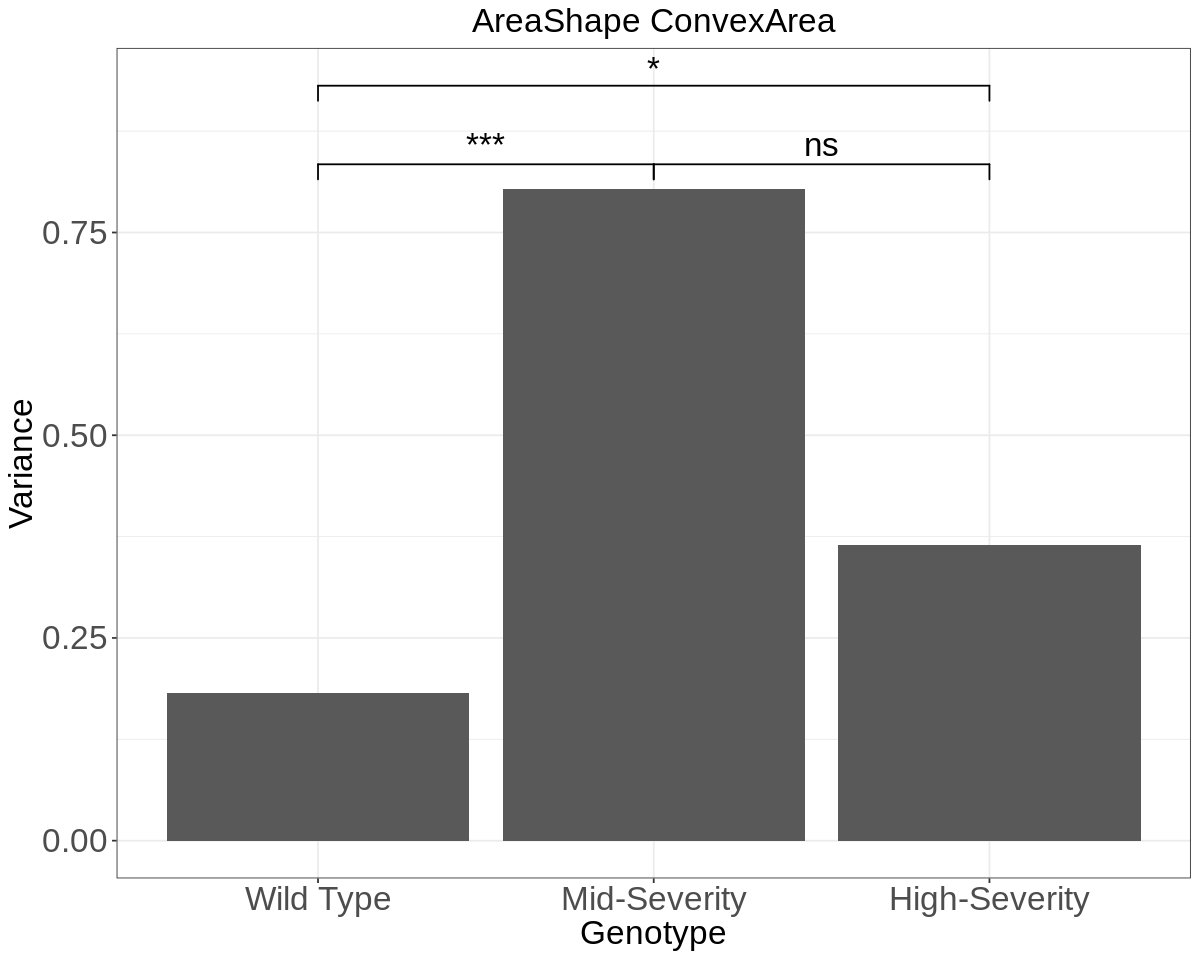

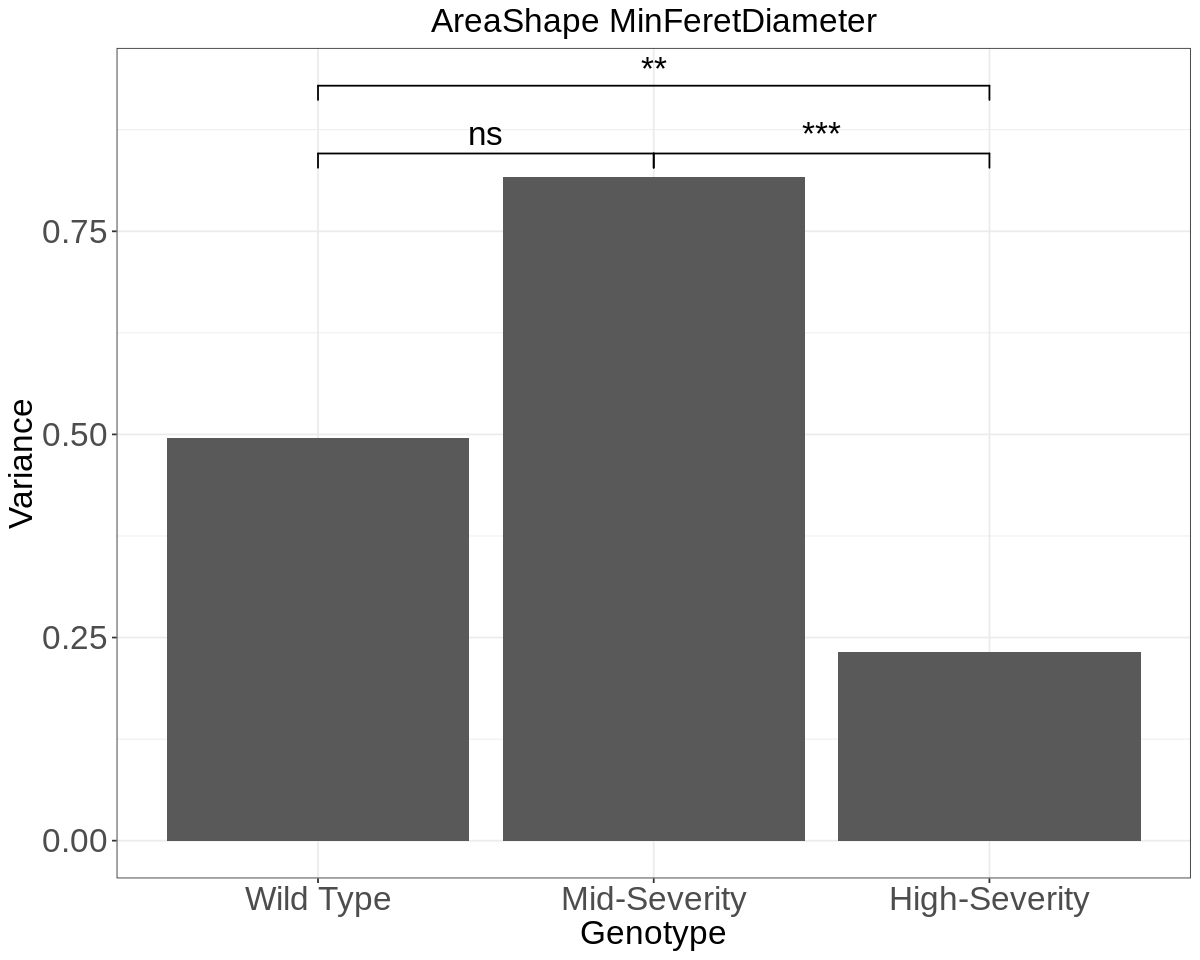

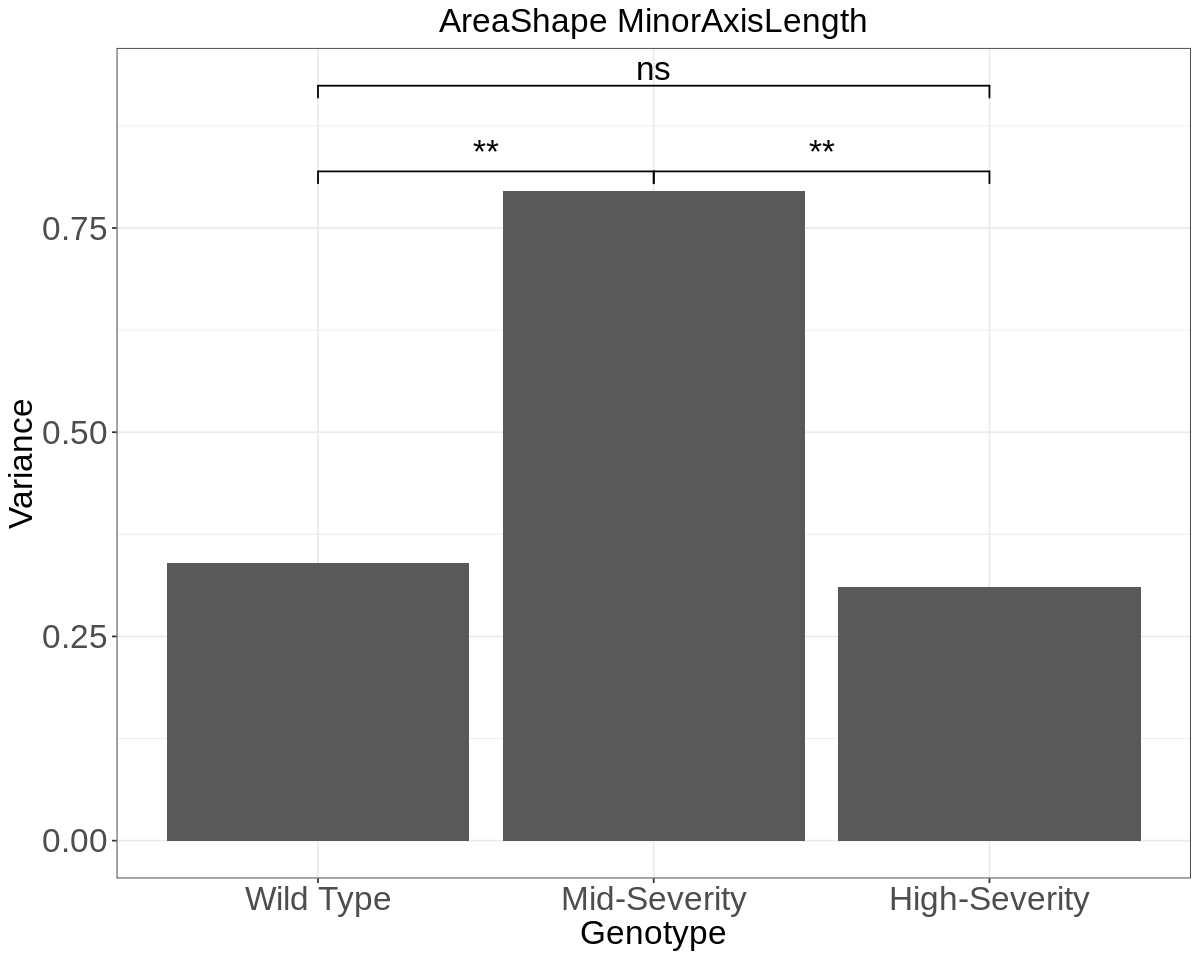

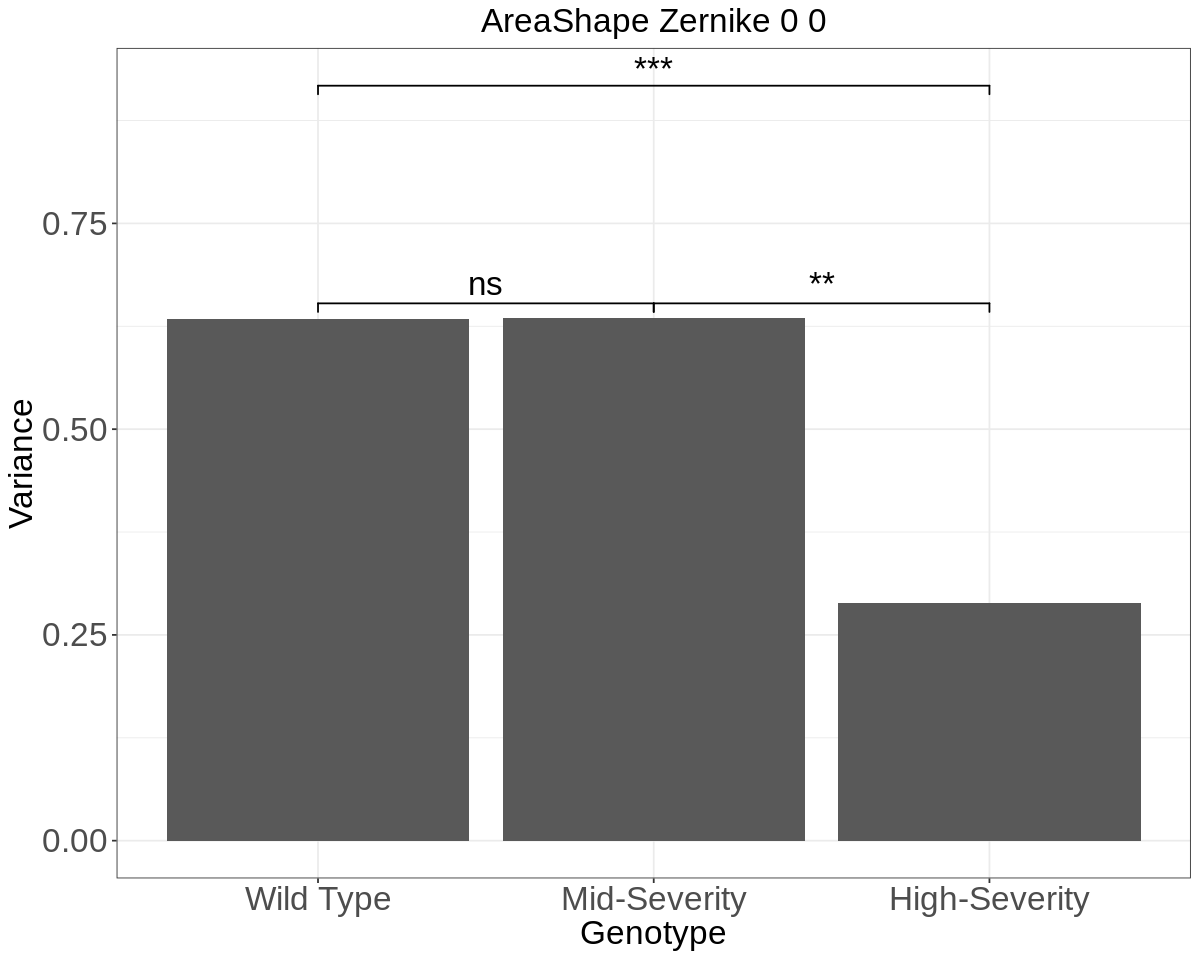

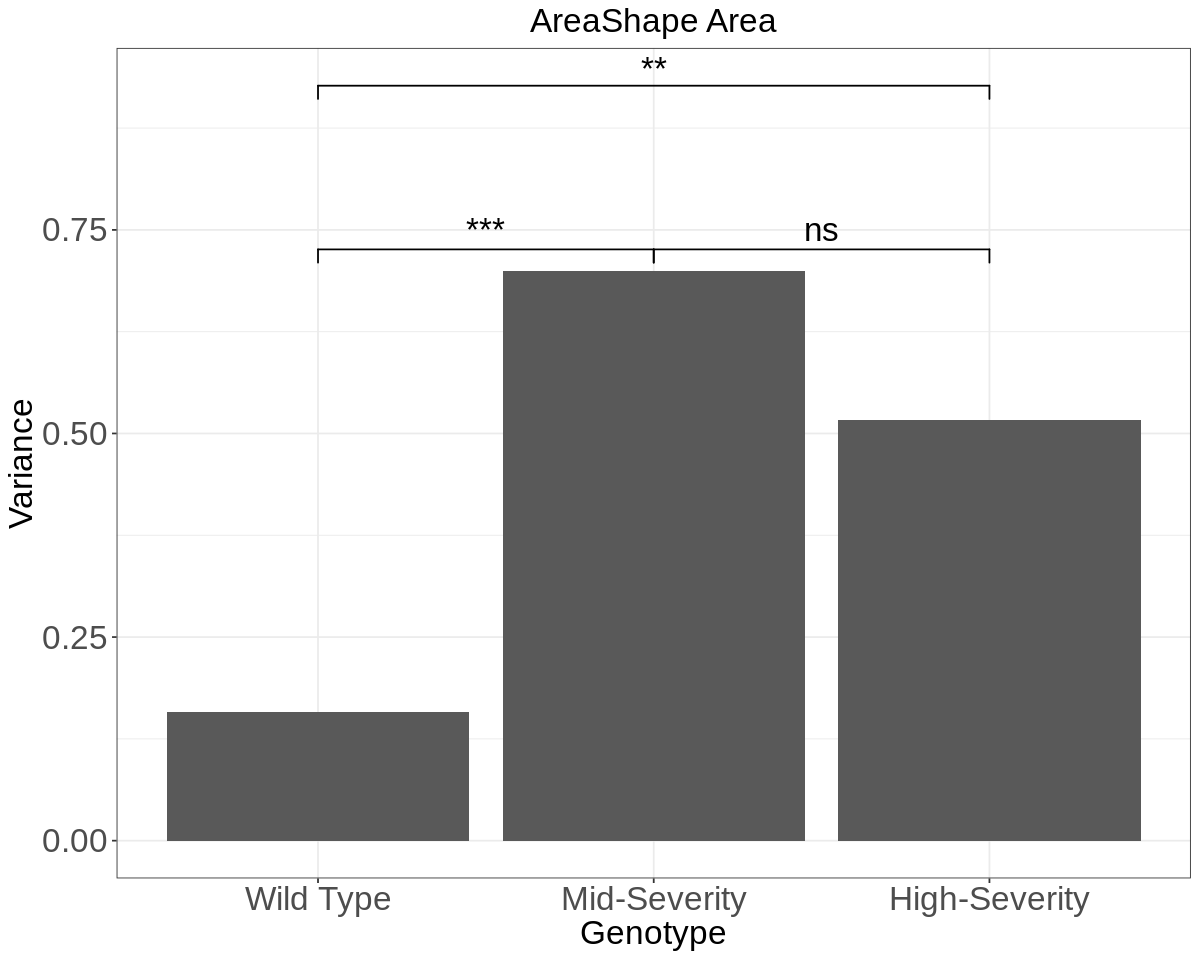

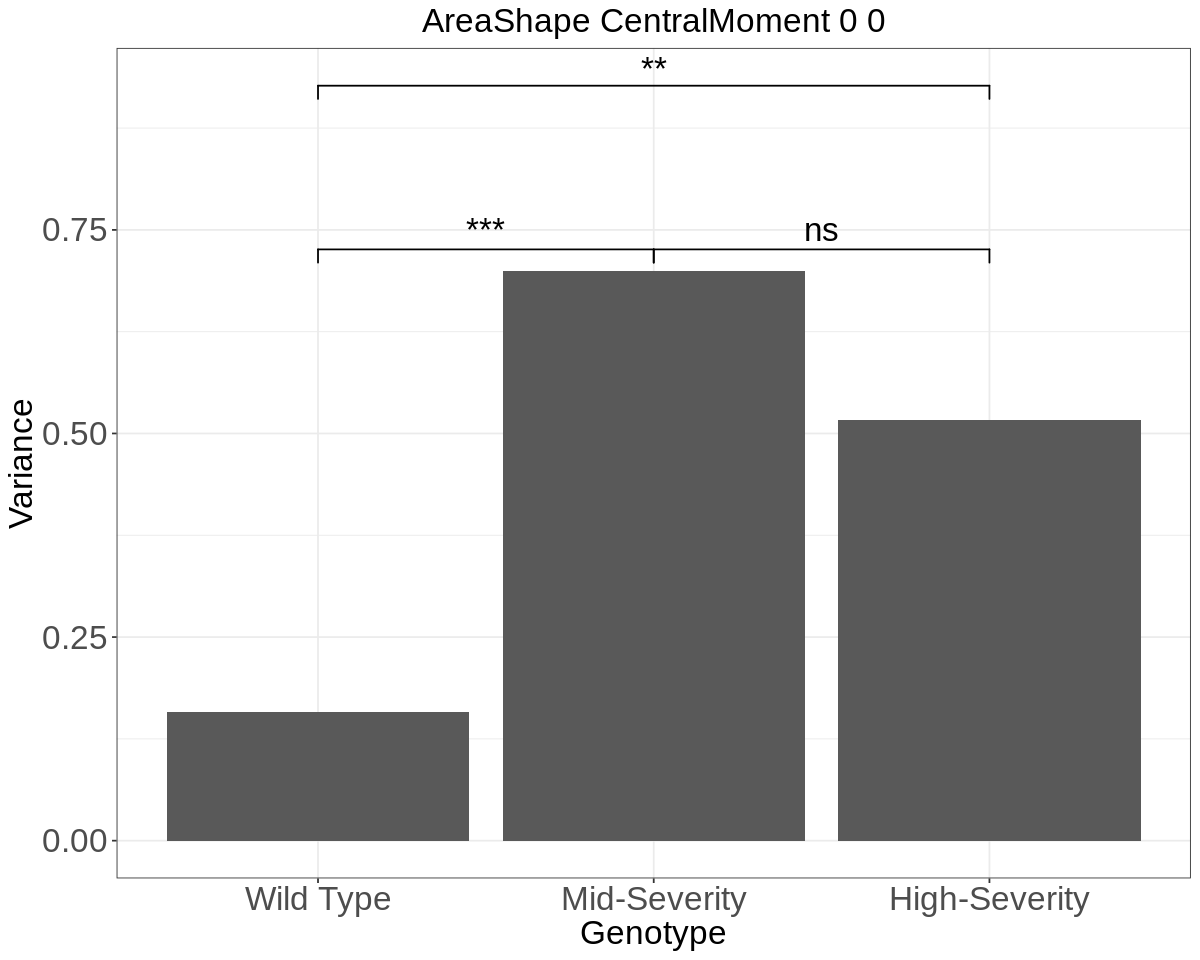

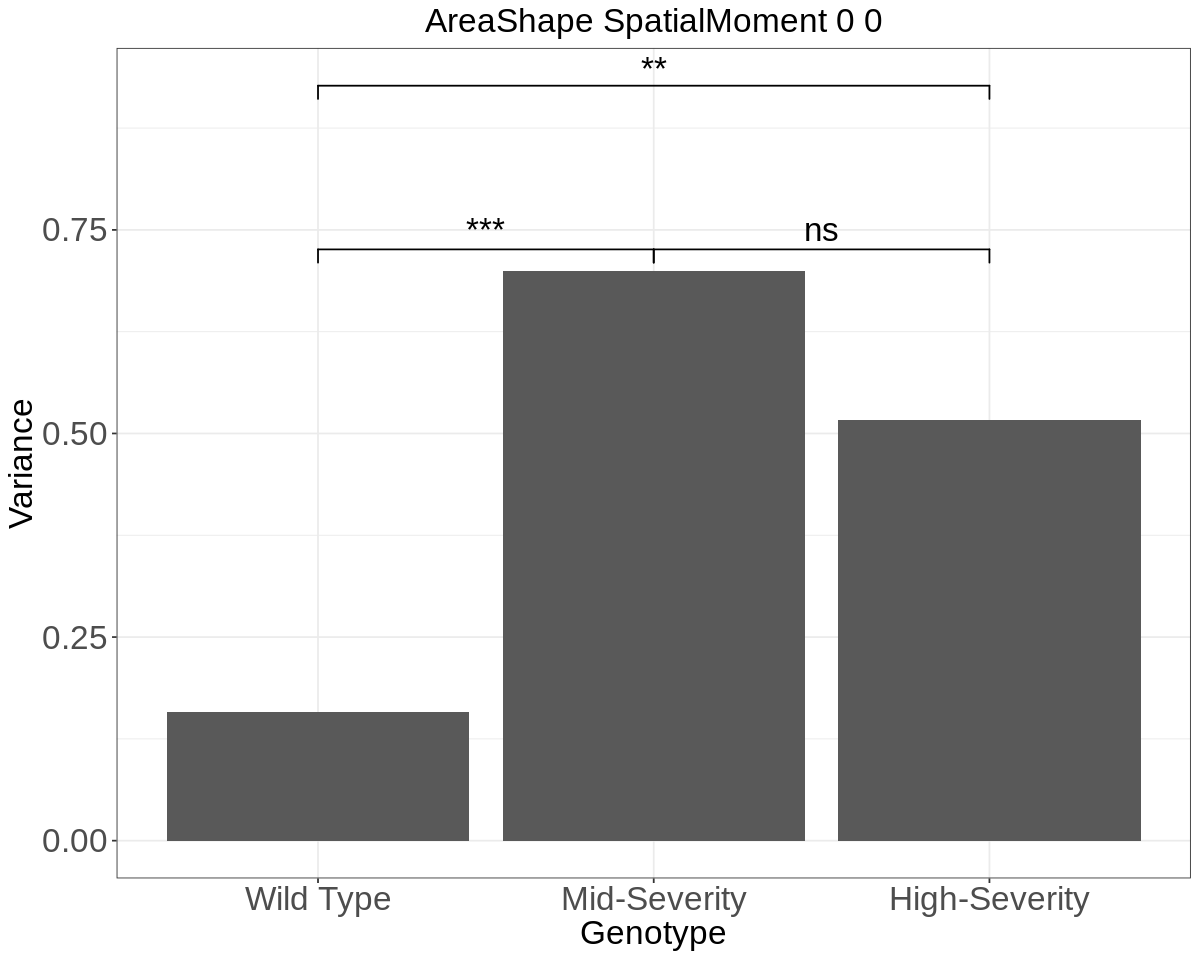

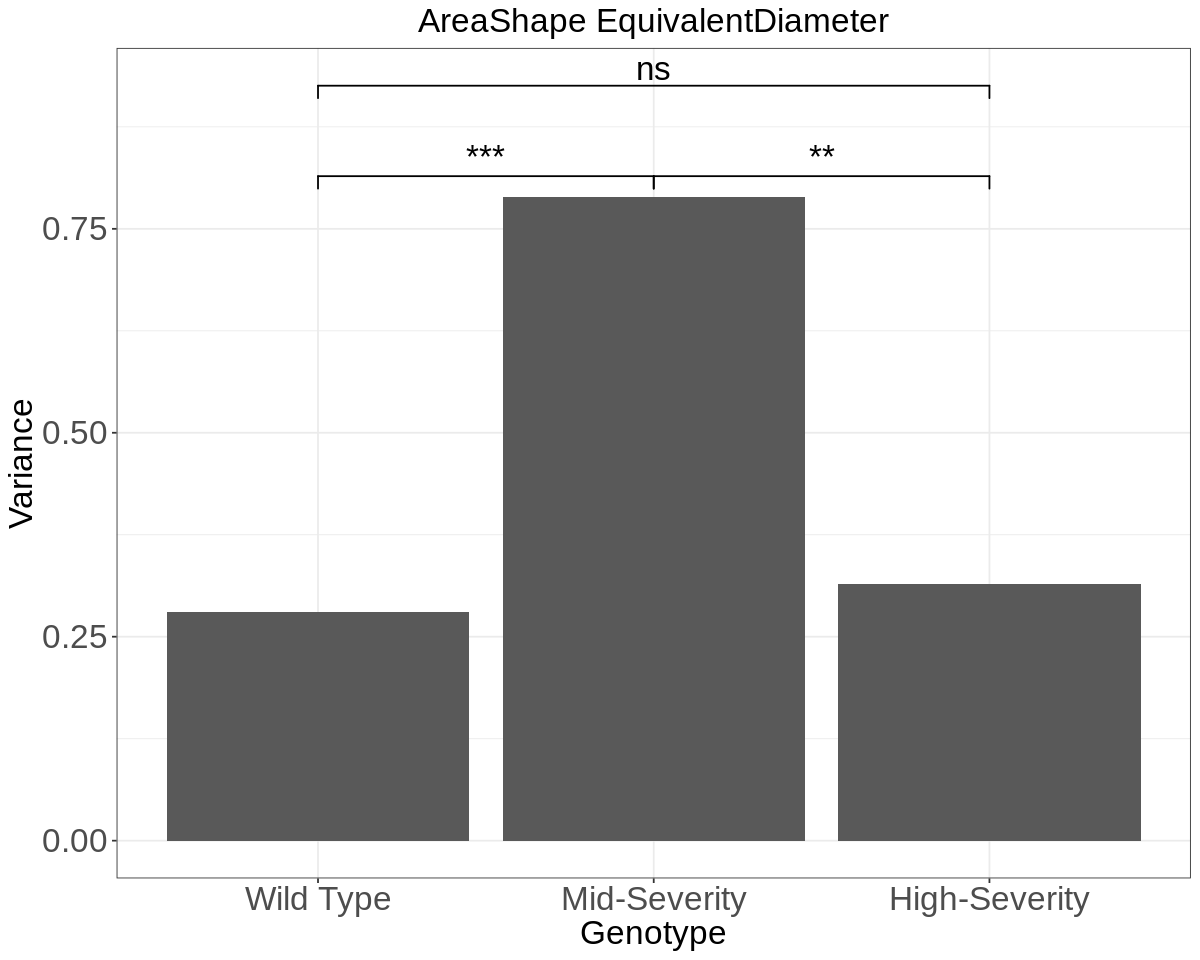

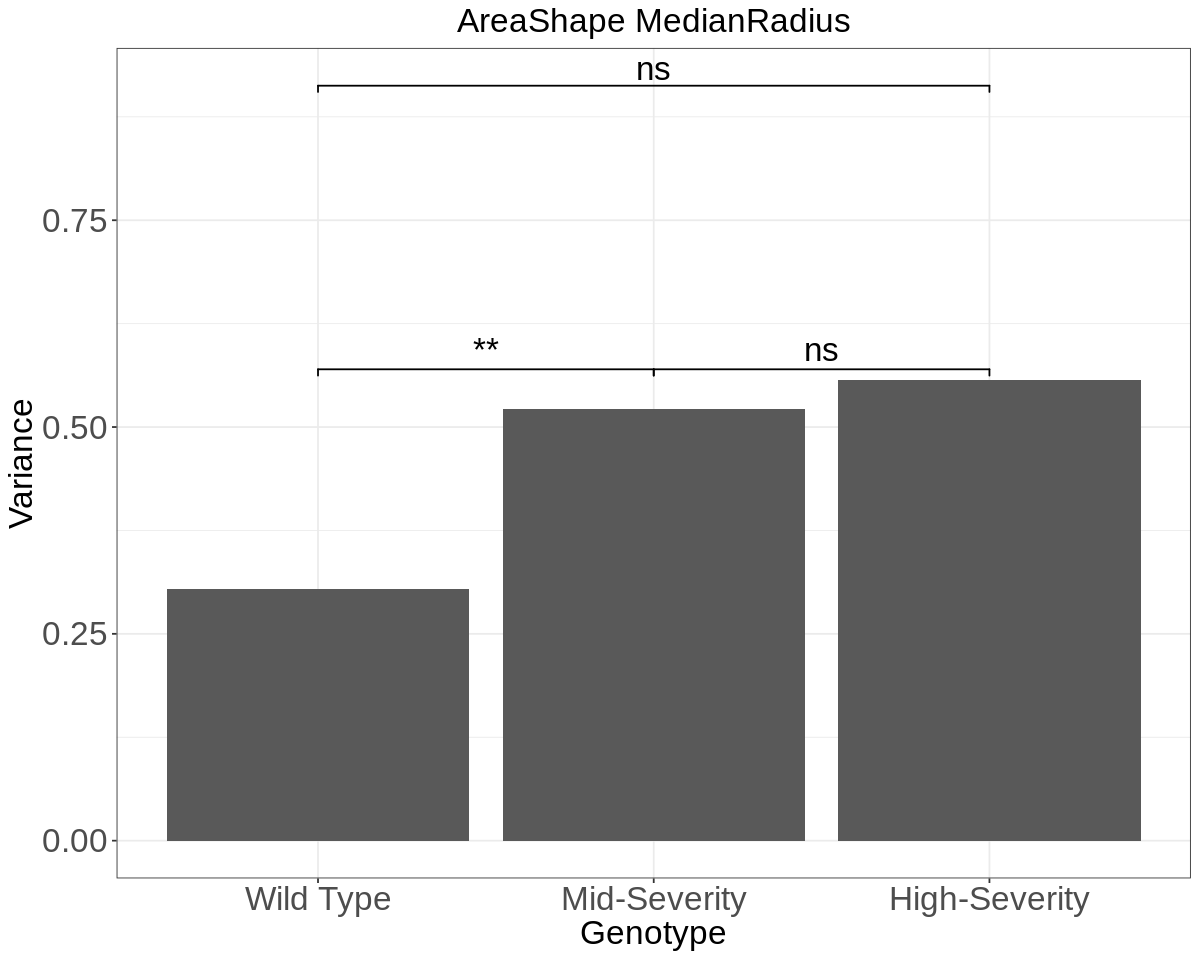

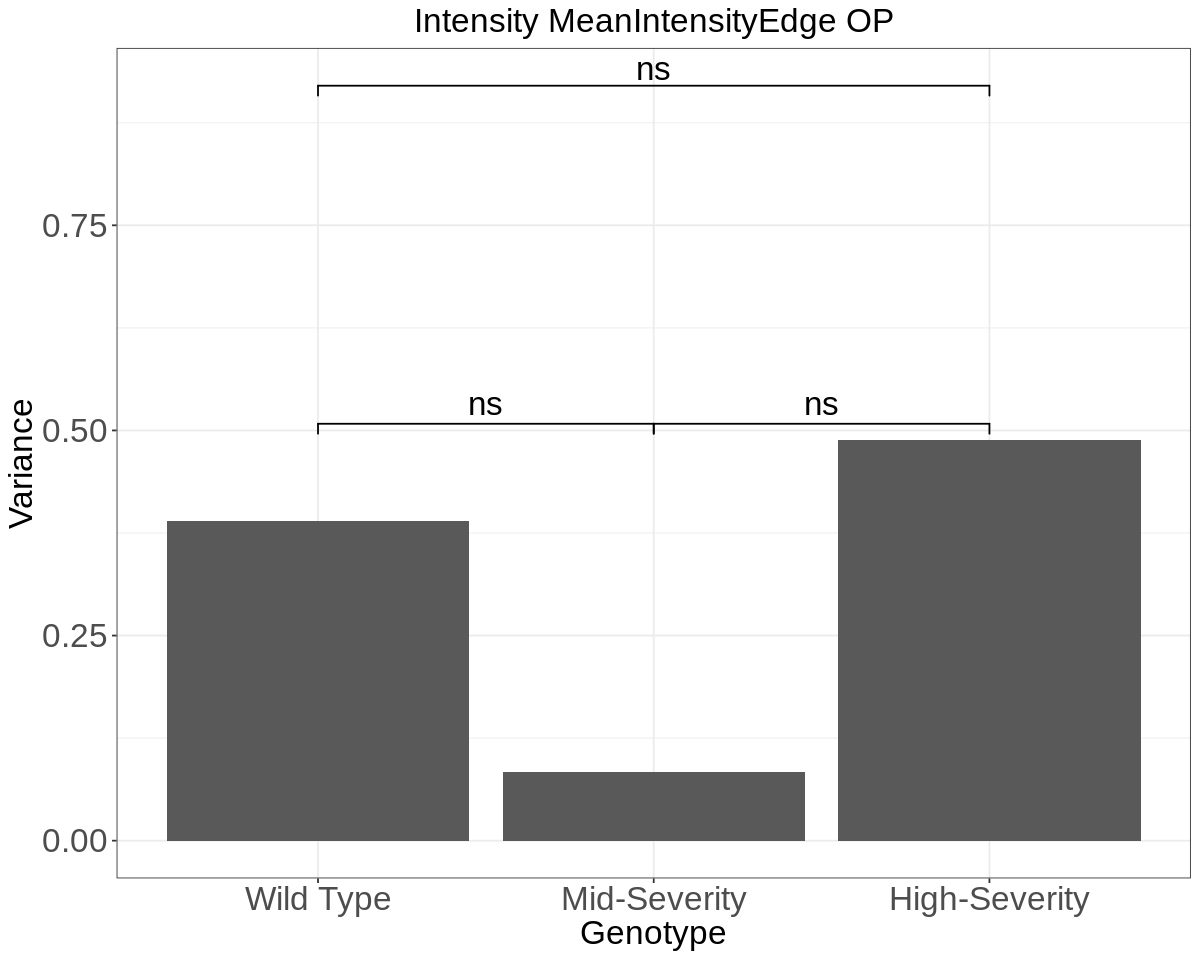

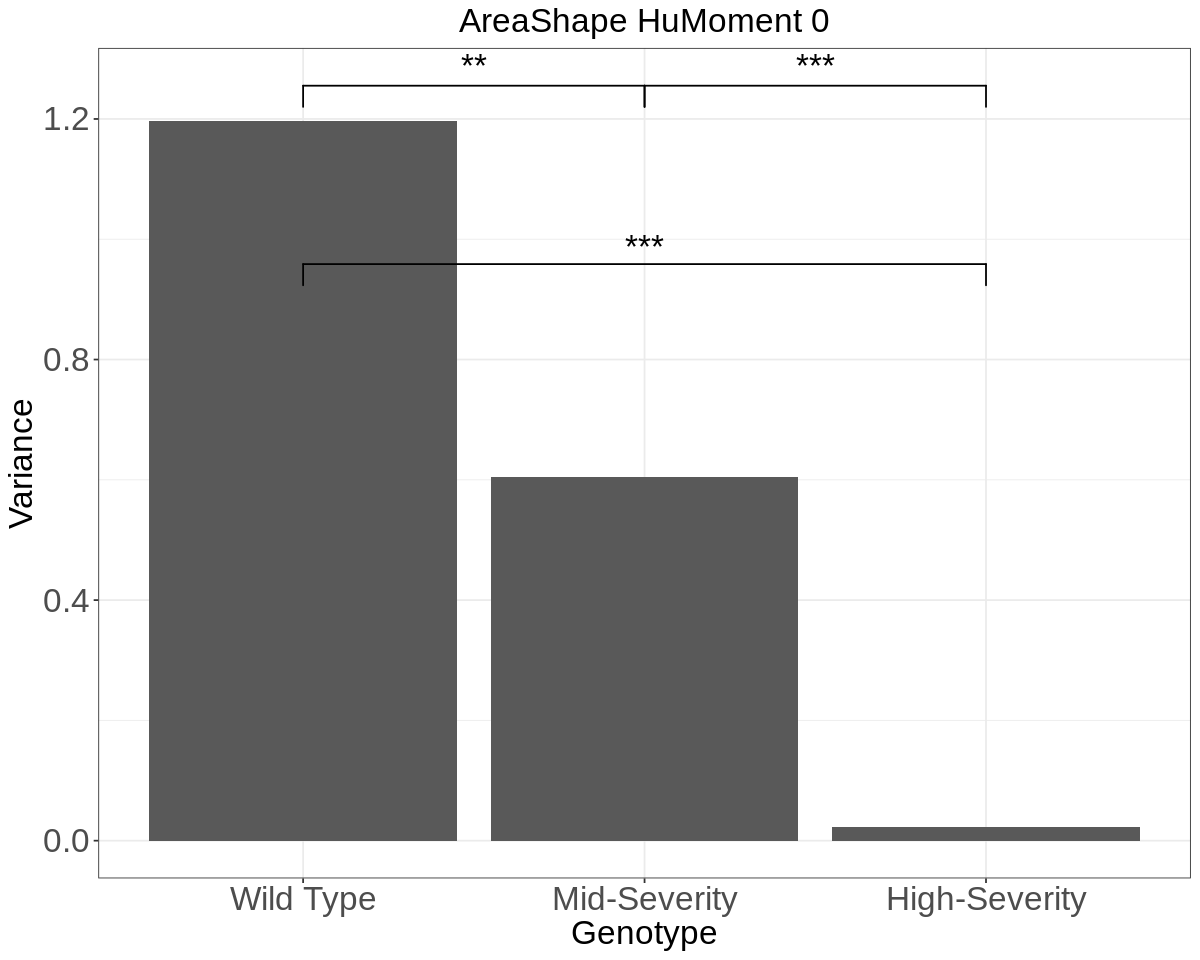

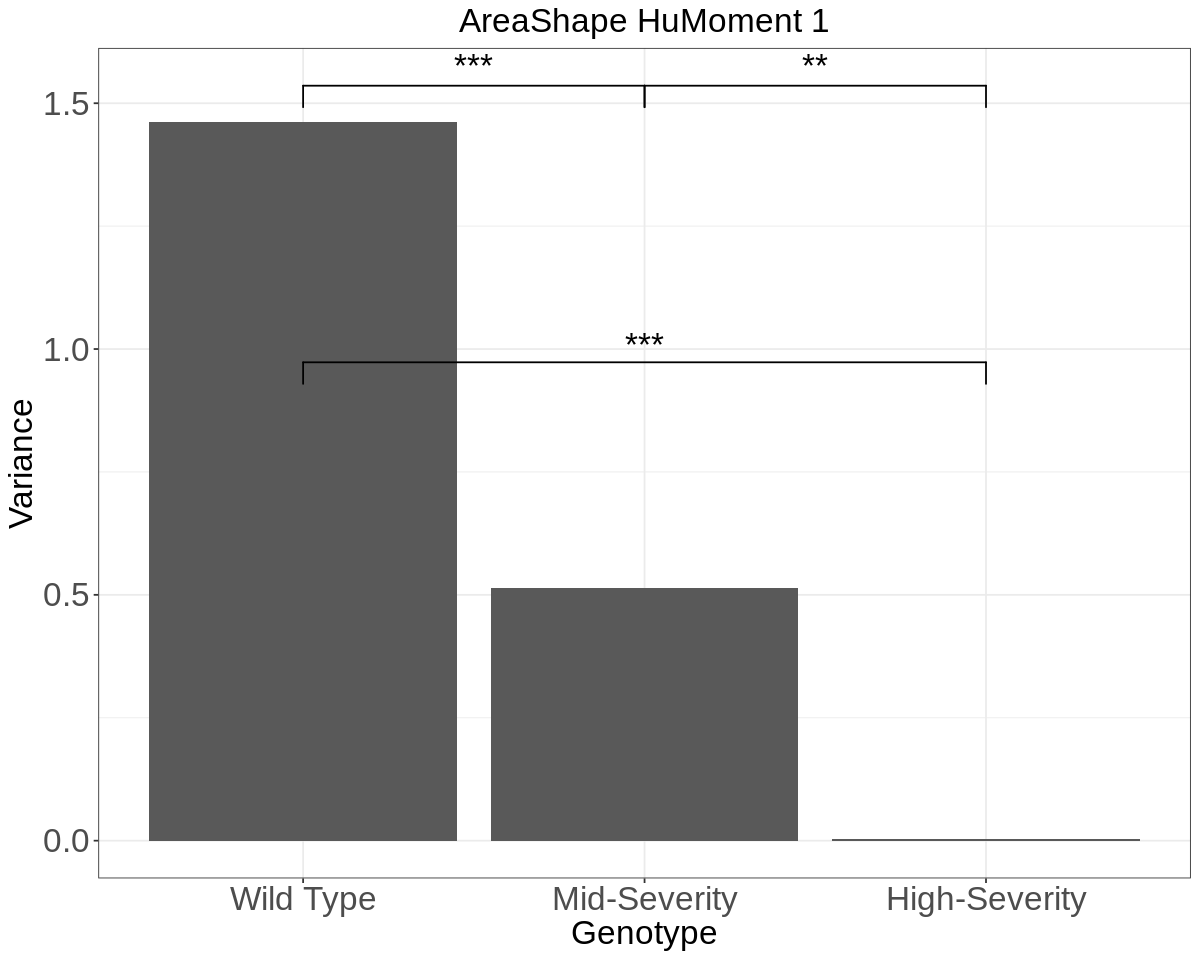

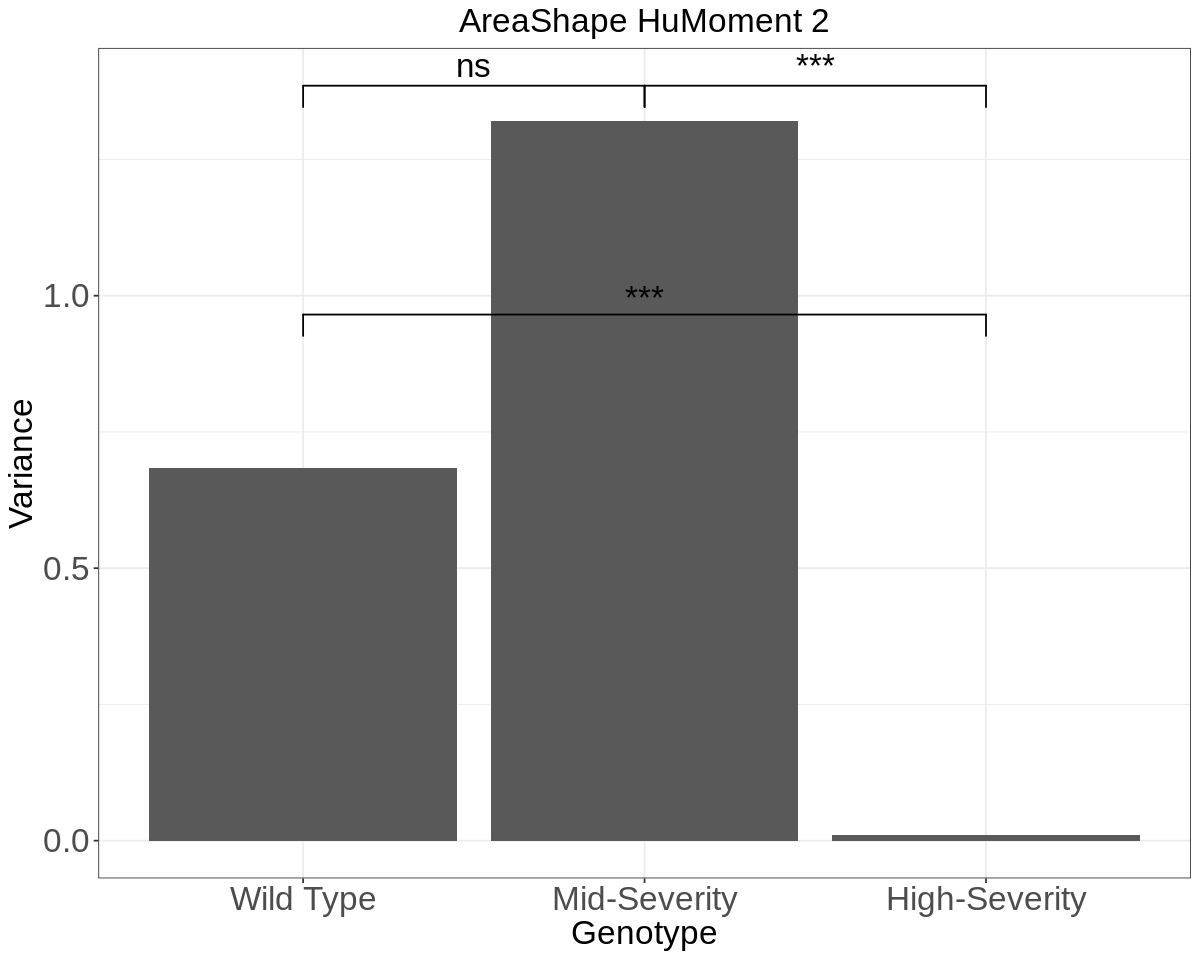

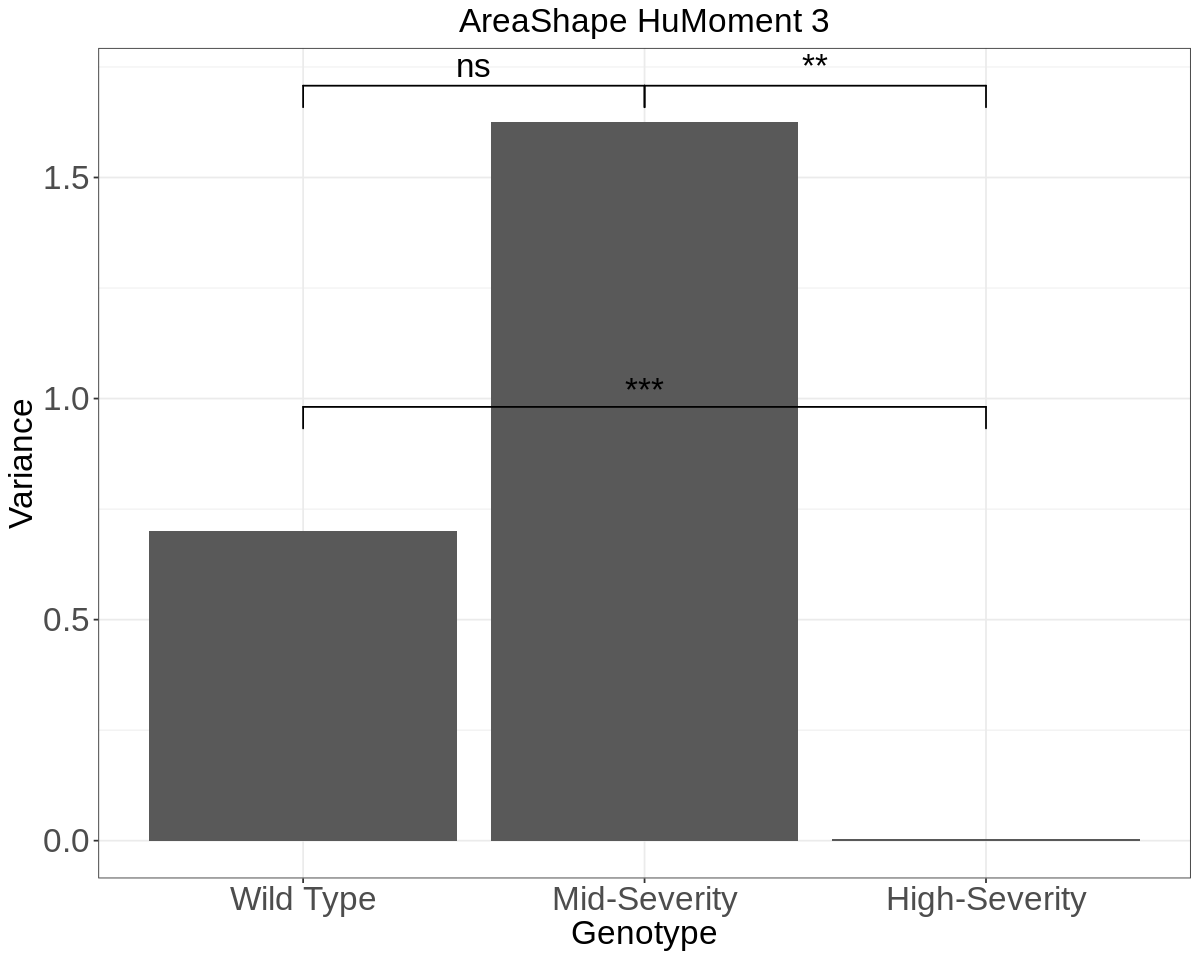

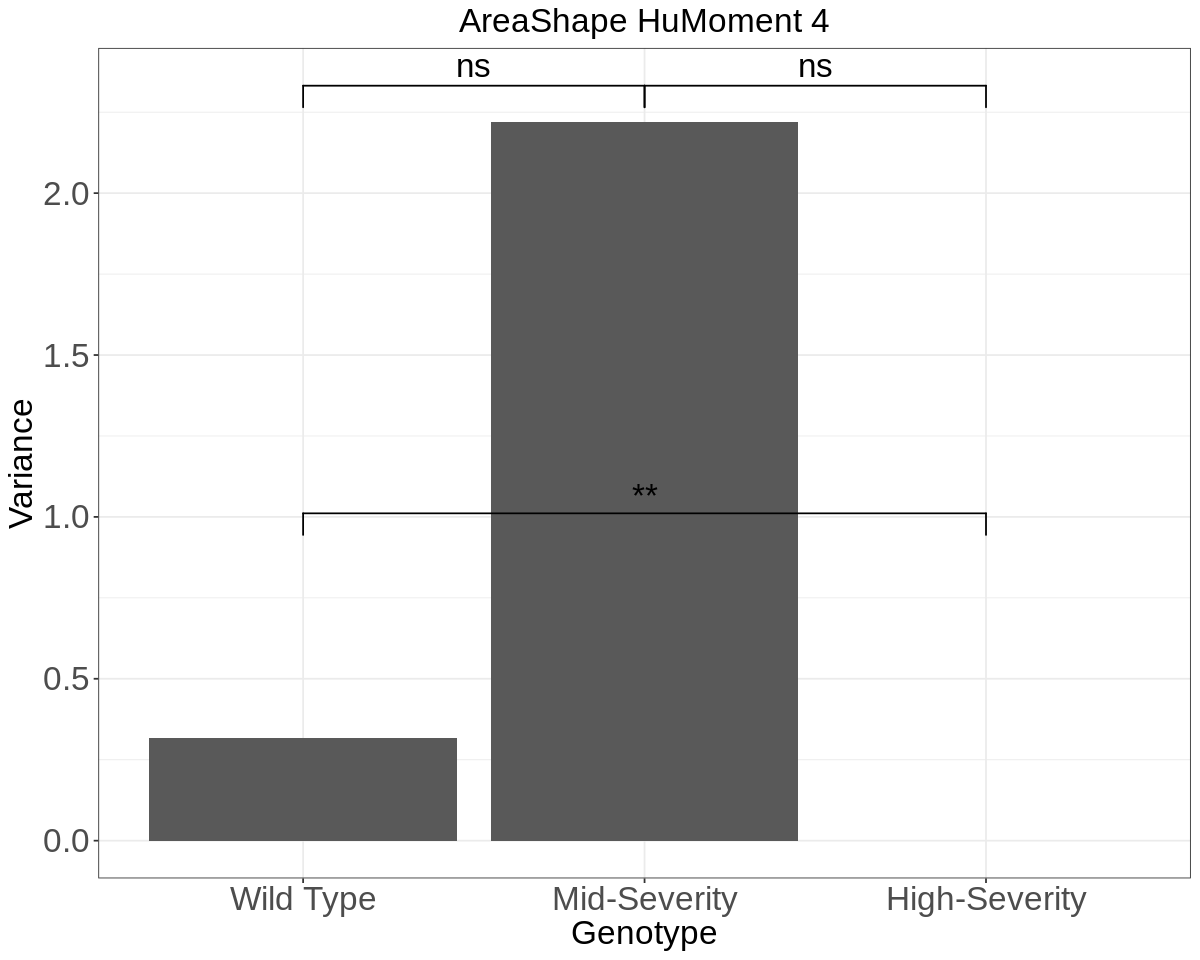

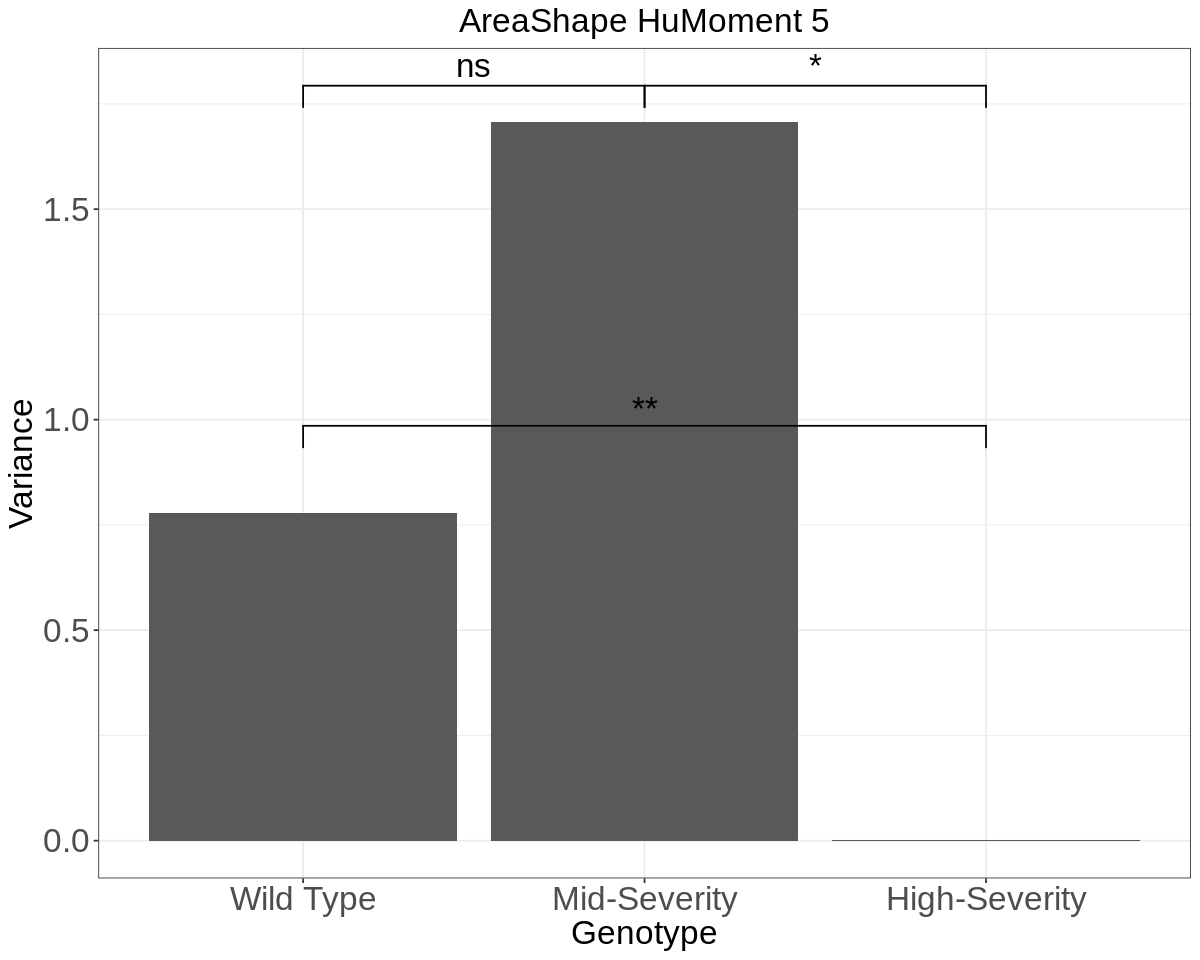

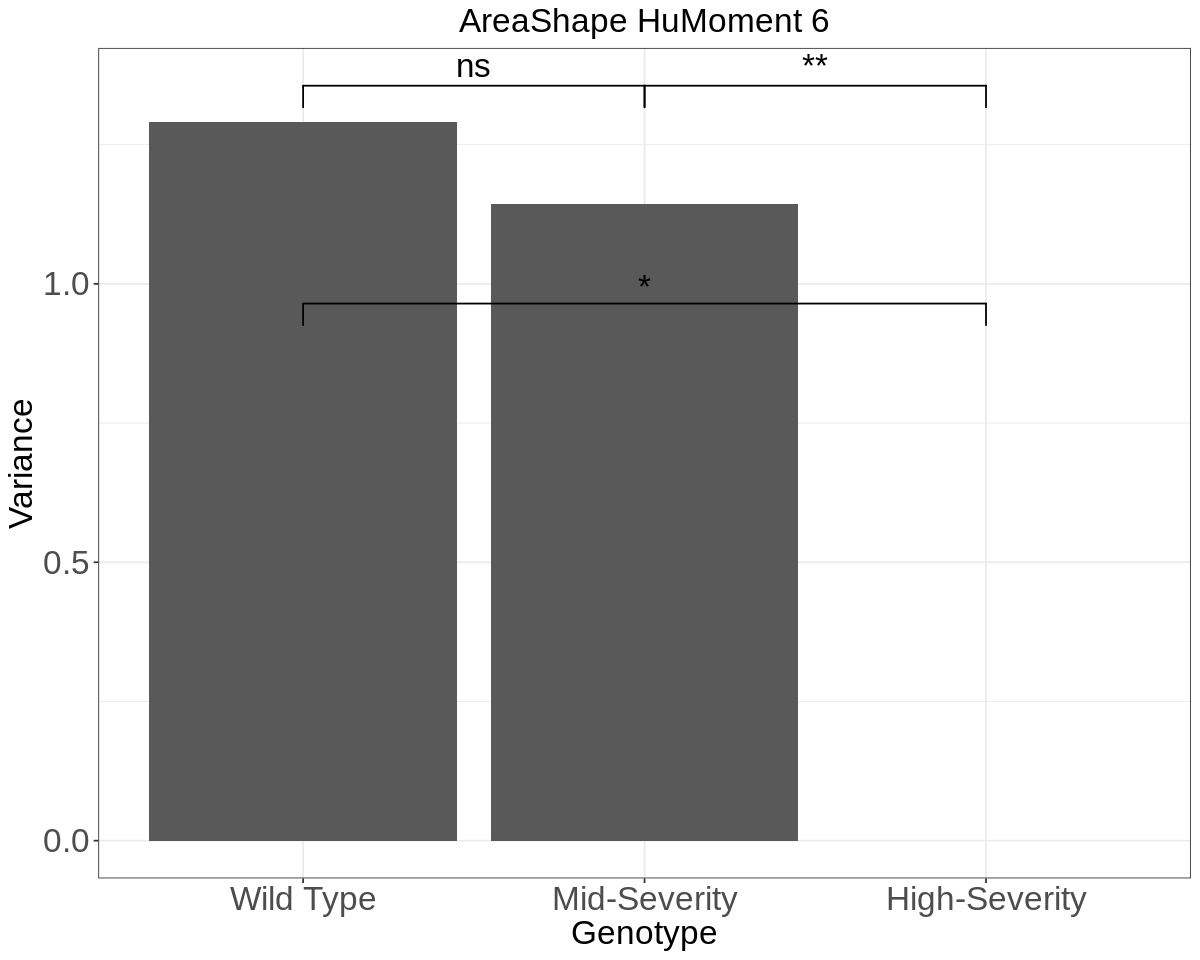

In [10]:
width <- 10
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
list_of_genotype_side_identity_anova_plots_split_by_genotype[[1]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[2]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[3]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[4]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[5]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[6]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[7]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[8]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[9]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[10]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[11]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[12]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[13]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[14]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[15]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[16]]
list_of_genotype_side_identity_anova_plots_split_by_genotype[[17]]
